In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'}]

In [3]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools


In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [9]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


In [10]:
graph = graph_builder.compile()

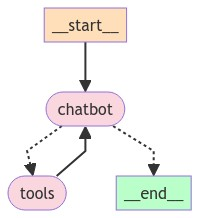

In [11]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
Assistant: It seems there was an issue with the search. Could you please provide more context or specify what you mean by "dox"? Are you looking for information on doxxing, a specific document, or something else?
Assistant: 
Assistant: [{"url": "https://www.apple.com/store", "content": "Important notice regarding the checkout receipt and monthly statement for Apple Card Monthly Installments (ACMI) purchases with this promotion: A purchase of an Eligible Product made when selecting ACMI (a 0% APR payment option available only in the U.S.) as the payment type at checkout will receive an instant credit equal to the cost of the Promotion Product (Apple Gift Card) deducted from the price of the Eligible Product at the time of purchase. \u25ca Apple Card Monthly Installments (ACMI) is a 0% APR payment option that is only available if you select it at checkout in the U.S. for eligible Appl